# How to replicate the European Commission DSA

This notebook features an tutorial for the stochastic DSA model replication introduced in "A Quantitative Evaluation of the European Commission´s Fiscal Governance Proposal" by Zsolt Darvas, Lennard Welslau, and Jeromin Zettelmeyer (2023). For details on the methodology see the [README](https://github.com/lennardwelslau/eu-debt-sustainability-analysis/blob/main/README.md) file and Annex A3 of the [European Commission's Debt Sustainability Monitor 2023](https://economy-finance.ec.europa.eu/publications/debt-sustainability-monitor-2023_en).

For comments and suggestions please contact lennard.welslau[at]gmail[dot]com.\
Last update: 01 June 2024

In [8]:
# Import libraries and modules
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.3f}".format
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Import DSA model class and stochastic subclass
from classes import *
from functions import *

# Set autoreleoad
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initializing the DSA model and projecting the debt ratio

Initialize model with country ISO code and adjustment period length. For deterministic projections the parent class "DsaModel" can be used, although I recommend always calling the StochasticDsaModel class to have access to all functionalities.

In [9]:
bel_dsa4 = DsaModel(country='BEL', adjustment_period=4)

Model functions (methods) and variables (attributes) can be inspected by typing the class name, followed by the attribute name. \
Explore the DsaModelClass and the StochasticDsaModelClass python files to see which attributes and methods exist.

In [10]:
bel_dsa4.ageing_cost

array([25.11216836, 25.35902661, 25.30438211, 25.42929057, 25.60866998,
       25.72537935, 25.86872455, 25.80469106, 25.93176262, 26.01668618,
       26.10791039, 26.1841957 , 26.30936245, 26.40669419, 26.52080311,
       26.594857  , 26.68438292, 26.72071055, 26.80365452, 26.84497823,
       26.94859525, 27.02029991, 27.15116563, 27.23184868, 27.36570423,
       27.44523852, 27.56918723, 27.64303992, 27.75526931, 27.82627099,
       27.94471488, 28.02307079, 28.14872417, 28.22890923, 28.35022875,
       28.41932622, 28.52620324, 28.58020844, 28.6788269 , 28.73220022,
       28.83952431, 28.90131935, 29.01595248, 29.08404081, 29.21529306,
       29.30357521, 29.44872925, 29.5572773 ])

We can project the debt ratio forward, assuming linear adjustment to a structural primary balance target using the "project" method. \
To project the model under specific scenario assumptions, pass the scenario name as a string. Deterministic scenarios are "main_adjustment", "adverse_r_g", "financial_stress", and "lower_spb".

In [11]:
bel_dsa4.project(spb_target=1.6, scenario='financial_stress')

For non-linear adjustment paths, for example due to an Excessive Deficit Procedure, we can specify each ajdustment step individually via the "adjustment_steps" attribute. \
Instead of specifying the steps manually, we can also call the "find_edp" method, which finds the number of periods in which, given the current SPB target, the minimum adjustment of 0.5% under the EDP is binding. The resulting minimum adjustment steps are updated automatically and saved in the "edp_steps" attribute. In cases where the entire adjustment period is needed to reach the 3% deficit targets, the adjustment step size is increased.

In [12]:
adjustment_steps = np.array([0.5, 0.5, 0.5, 0])
bel_dsa4.project(adjustment_steps=adjustment_steps,
                scenario='main_adjustment')
bel_dsa4.adjustment_steps

array([0.5, 0.5, 0.5, 0. ])

We can show the resulting debt ratio and primary balance path using the "df" method. \
The "df" method takes strings of the model variables or a dictionary with model variables and desired column names as input argument and returns a pandas dataframe. If the method is called without specified variables, it returns a dataframe with the structural primary balance, the overall balance, and the debt ratio. 

In [13]:
bel_dsa4.df().iloc[1:7]

,,d,ob,sb,spb_bca,spb_bca_adjustment
t,y,,,,,
1,2024,104.804,-4.261,-4.021,-1.869,0.309
2,2025,106.303,-4.274,-3.632,-1.369,0.500
3,2026,106.534,-3.914,-3.255,-0.869,0.500
4,2027,106.316,-3.452,-2.854,-0.369,0.500
5,2028,105.348,-3.156,-2.926,-0.369,0.000
6,2029,104.848,-3.217,-3.141,-0.369,0.000


If the df method is called with parameter "all" set to "True", a preset list of variables will be included. The included variables are listed below.

In [14]:
bel_dsa4.df(all=True).columns

Index(['d', 'spb_bca', 'spb_bca_adjustment', 'spb', 'pb', 'ob', 'sb',
       'interest_ratio', 'ageing_cost', 'rg', 'rg_pot', 'ng', 'output_gap',
       'output_gap_bl', 'fm_effect', 'pi', 'rgdp_pot', 'rgdp', 'ngdp', 'i_st',
       'i_lt', 'iir_lt', 'iir', 'sf', 'D', 'D_lt_esm', 'D_st', 'D_lt',
       'repayment', 'repayment_lt', 'repayment_lt_esm', 'interest',
       'interest_lt', 'interest_st'],
      dtype='object')

### Deterministic Optimization

The "find_spb_deterministic" optimizes for a structural primary balance at the end of the adjustment period that meets the specified deterministic scenario criterion. Additional parameters, like initial adjustment periods, that have been specified in the initial projection, are taken as given.\
The criterion can be any of 'main_adjustment', 'lower_spb', 'financial_stress', 'adverse_r_g', 'deficit_reduction', or 'debt_safeguard'. \
Note that the debt_safeguard is applied from the end of the Excessive Deficit Procedure. Because the end of the EDP may vary with the size of annual adjustments, the debt safeguard may produce a different target when applied by itself or after having optimized for other criteria. In our analysis, we apply the debt safeguard conditional on the toughest scenario path.

In [15]:
bel_dsa4.find_spb_deterministic(criterion='adverse_r_g')

1.0943999999998324

The model projections are updated automatically to the optimal SPB target and we can plot the resulting debt ratio projection, for example by using the "df" method and pandas' built-in plotting function.\
Here we plot the ageing-cost adjusted structural primary balance, as well as the structural primary balance that includes ageing costs, the overall balance, and the debt ratio.

<Axes: title={'center': 'Belgium: Debt ratio and balance'}, xlabel='(t, Year)'>

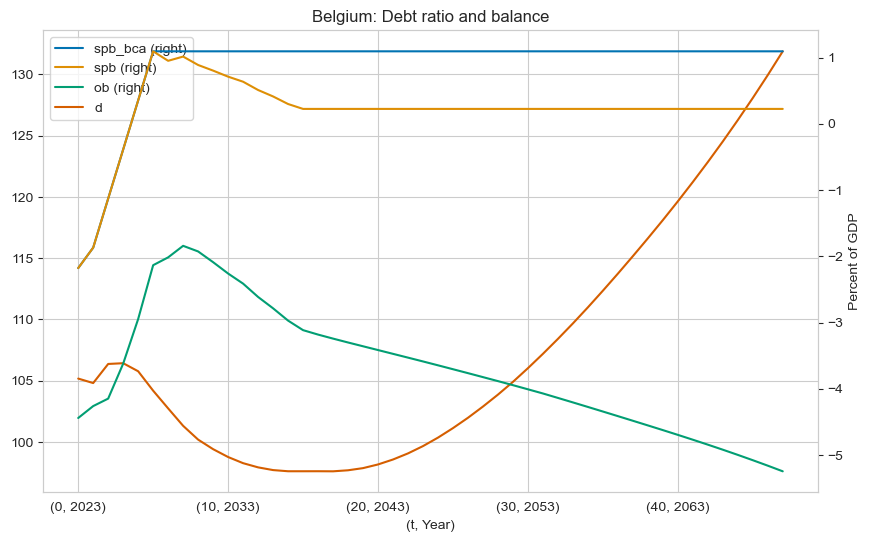

In [16]:
bel_dsa4.df('spb_bca', 'spb',  'ob', 'd').plot(
    title='Belgium: Debt ratio and balance', 
    secondary_y=['spb', 'spb_bca', 'ob'], 
    ylabel='Percent of GDP', 
    xlabel='(t, Year)', 
    legend=True, 
    figsize=(10, 6))

### Stochastic Optimization

The StochasticDsaModel class is a subclass of the DsaModel and inherits all its functionalities. It is initiated analogously.

The latest update introuces a number of addiitonal parameters that can be altered to test model assumptions. These include:
- "ageing_cost_period" to specify the post-adjustment window during which ageing costs are seperated out from SPB 
- "shock_frequency" to specify the underlying shock data frequenct as "quarterly" or annual"
- "shock_sample_start" for the start of the sampled shock data
- "stochastic_start_year" for the start of the fanchart, ie the period form which unceirtainty is incorporated into projections

In [17]:
esp_sdsa7 = StochasticDsaModel(country='ESP', adjustment_period=7)

After projecting the debt path, the "simulate" method simulates N projections based on shocks to growth, interest rate, exchange rate, and primary balance.

In [18]:
esp_sdsa7.project()
esp_sdsa7.simulate(N=100000)

The "fanchart" method plots the percentiles of the simulated distribution of the debt ratio. If the save_df option is specified, we can access the underlying percentile data as new model attribute. The period parameter determines the number of projection periods. The Commission methodology uses 5.

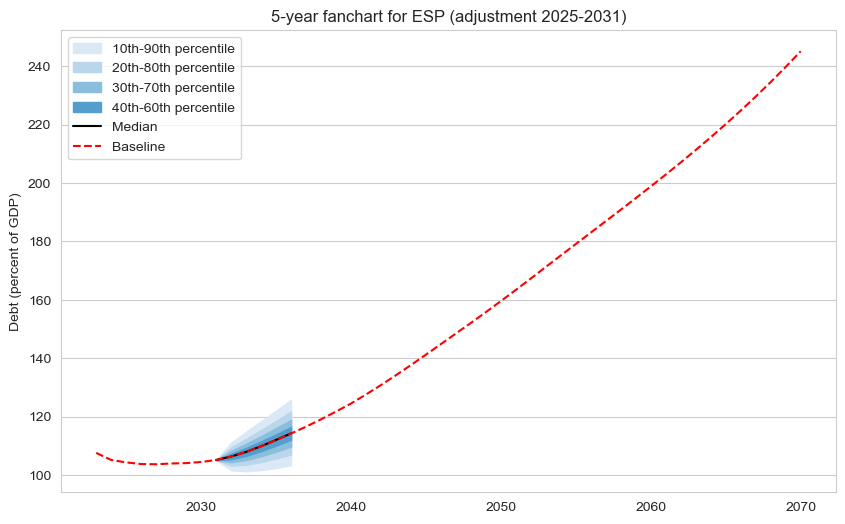

In [19]:
esp_sdsa7.fanchart()

In [20]:
esp_sdsa7.df_fanchart.dropna()

,year,baseline,p10,p20,p30,p40,p50,p60,p70,p80,p90
8,2031,105.204,105.204,105.204,105.204,105.204,105.204,105.204,105.204,105.204,105.204
9,2032,106.366,101.709,103.294,104.450,105.456,106.389,107.309,108.323,109.504,111.139
10,2033,107.967,101.353,103.608,105.238,106.646,107.976,109.324,110.767,112.473,114.863
11,2034,109.896,101.756,104.515,106.524,108.266,109.915,111.585,113.373,115.478,118.492
12,2035,112.011,102.459,105.748,108.081,110.161,112.071,113.973,116.103,118.567,122.120
13,2036,114.263,103.477,107.103,109.798,112.133,114.315,116.537,118.972,121.824,125.837


The "find_spb_stochastic" method optimizes for the primary balance path that ensures no more than 30% of simulated debt ratio paths are increasing. The probability target and the period over whcih the fanchart and the criterion are applied can be changed from their default values.

In [21]:
esp_sdsa7.find_spb_stochastic(prob_target=0.3)

1.6638781967813079

### Integrated optimization

To quickly calculate all scenarios and detmerine which is binding, we can call the "find_spb_binding" method. Note that this method is only available after initalizing a stochastic model. \
The method determines optimal SPB targets for all deterministic and stochastic DSA criteria, as well as for the 3% deficit criteria. If no spcified differently, the method then checks whether the EDP or either of the two safeguards, the debt and the deficit resilience safeguard, are violated and corrects the binding SPB target accordingly.

In [22]:
esp_sdsa7.find_spb_binding(
    save_df=True, 
    edp=True, 
    debt_safeguard=True, 
    deficit_resilience=True
    )

                  Model Params                             SPB Targets       
================================================     ========================
country                                      ESP     main_adjustment    2.109
adjustment period                              7     lower_spb          2.600
adjustment start                            2025     financial_stress   2.148
shock frequency                        quarterly     adverse_r_g        2.778
stochastic period                      2032-2037     deficit_reduction  2.276
estimation                               normal      stochastic         1.659
bond level data                            False     binding            2.778
safeguards         EDP, debt, deficit_resilience                             
================================================     ========================

                                Binding Params                               
adjustment_steps              0.518, 0.518, 0.518, 0.518, 0.518

The "find_spb_binding" method saves a dictionaries with the binding targets and timeseries for all scenarios. In addition, it saves the projection parameters of the binding scenario for quick replication.

In [23]:
esp_sdsa7.spb_target_dict

{'main_adjustment': 2.108699999999828,
 'lower_spb': 2.5996999999998196,
 'financial_stress': 2.147899999999825,
 'adverse_r_g': 2.7778999999998115,
 'deficit_reduction': 2.2756999999998175,
 'stochastic': 1.6585322517664998,
 'binding': 2.7778999999998115}

In [24]:
esp_sdsa7.df_dict['binding'].head()

,,d,spb_bca,spb_bca_adjustment,spb,pb,ob,sb,interest_ratio,ageing_cost,rg,...,D,D_lt_esm,D_st,D_lt,repayment,repayment_lt,repayment_lt_esm,interest,interest_lt,interest_st
t,y,,,,,,,,,,,,,,,,,,,,,
0,2023,107.652,-1.631,NaN,-1.631,-1.176,-3.636,-4.091,NaN,23.188,2.503,...,"1,573.800",-0.000,89.822,"1,483.978",NaN,NaN,4.575,NaN,NaN,NaN
1,2024,105.229,-0.849,0.782,-0.849,-0.265,-2.787,-3.371,2.522,23.256,2.145,...,"1,623.708",-4.575,94.235,"1,534.048",225.745,131.348,4.575,38.882,35.951,2.931
2,2025,104.512,-0.331,0.518,-0.331,0.019,-2.549,-2.899,2.568,23.305,1.635,...,"1,679.704",-8.218,98.673,"1,589.249",232.947,135.070,3.643,41.183,37.920,3.263
3,2026,103.561,0.187,0.518,0.187,0.189,-2.503,-2.505,2.692,23.381,1.031,...,"1,721.213",-11.861,102.517,"1,630.557",242.505,140.190,3.643,44.636,41.236,3.400
4,2027,102.524,0.705,0.518,0.705,0.435,-2.348,-2.078,2.783,23.486,0.985,...,"1,761.446",-11.861,104.926,"1,668.381",243.014,140.497,0.000,47.695,44.179,3.515


In [25]:
esp_sdsa7.binding_parameter_dict

{'adjustment_steps': array([0.51812857, 0.51812857, 0.51812857, 0.51812857, 0.51812857,
        0.51812857, 0.51812857]),
 'spb_target': 2.7778999999998115,
 'criterion': 'adverse_r_g',
 'edp_binding': False,
 'edp_steps': array([nan, nan, nan, nan, nan, nan, nan]),
 'debt_safeguard_binding': False,
 'deficit_resilience_binding': False,
 'deficit_resilience_steps': array([nan, nan, nan, nan, nan, nan, nan]),
 'net_expenditure_growth': array([2.84135086, 2.22341899, 2.17687307, 2.27775199, 2.52874509,
        2.38624727, 2.22899384])}

### Running the DSA for all countries
The functions in the functions folder contian preset loops that run the DSA for all countries, save and plot results. Simply run the "main.ipynb".

### Additional functionality
The model offers methods and parameters for addiitonal analysis and the exploration of methodological assumptions

The "find_deficit_prob" method builds on the stochastic model to calculate the probabilites of an excessive deficit in each year of the adjustment period. \
We can either call it directly by specifying an adjustment path or call it after we have optimized the path as above.

Text(0.5, 1.0, 'Spain: Probability of deficit during 7-year adjustment')

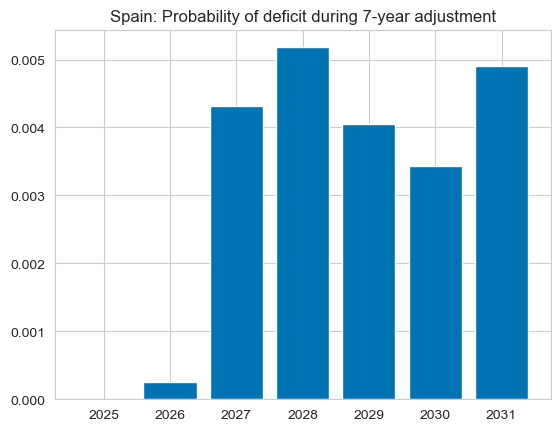

In [26]:
prob_deficit = esp_sdsa7.find_deficit_prob()
plt.bar(np.arange(2025, 2032), prob_deficit)
plt.title('Spain: Probability of deficit during 7-year adjustment')

The function "run_multiple_periods" from the functions package can be used to to simulate consecutive adjustment periods and gain insight into which criteria would be bindin in future applications of the fiscal rules. It initial optimization for a given adjustment period, saves the net expenditure path, and optimizes the next period, taking the first period's path as given.

                  Model Params                              SPB Targets        
================================================     ==========================
country                                      FRA     main_adjustment     -0.016
adjustment period                              7     lower_spb            0.541
adjustment start                            2025     financial_stress     0.392
shock frequency                        quarterly     adverse_r_g          0.802
stochastic period                      2032-2037     deficit_reduction    0.758
estimation                               normal      stochastic           0.590
bond level data                            False     edp                  0.795
safeguards         EDP, debt, deficit_resilience     deficit_resilience   0.820
                                                     binding              0.820
================================================     ==========================

                                 Bindin

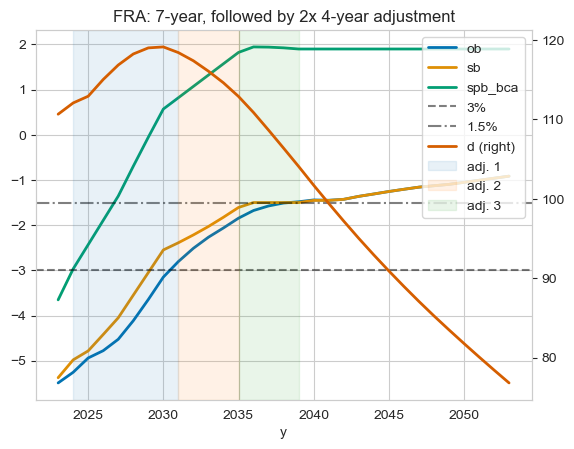

,main_adjustment,lower_spb,financial_stress,adverse_r_g,deficit_reduction,stochastic,edp,deficit_resilience,binding
adjustment_period_1,-0.016,0.541,0.392,0.802,0.758,0.590,0.795,0.820,0.820
adjustment_period_2,-0.045,0.416,0.421,0.829,0.666,0.489,0.828,1.822,1.822
adjustment_period_3,0.204,0.712,0.273,1.030,0.535,0.439,1.030,1.900,1.900


In [34]:
run_consecutive_dsa(
        country = 'FRA',
        start_year=2024, 
        initial_adjustment_period=7, 
        consecutive_adjustment_period=4, 
        number_of_adjustment_periods=3, 
        print_results=True,
        plot_results=True)

Finally, the StochasticDsaModel Class offers several additional parameters choices that differ from the assumptions of the European Commission:
- The period over which ageing costs affect SPB following the end of the adjustment period
- The sample cutoff for stochastic shocks
- The frequency of the shock data
- The start and the length of stochastic projections (allowing for example to consider shocks during the adjustment period to all variables except for the primary balance)
- The estimation methodology for stochastic shocks (either via joint-normal distribution or a VAR using either a bootstrap or a cholesky decomposition)
- The size of the fiscal multiplier
- The use of bond level data for the term structure of existing long-term debt 
- The use of a policy counterfactual which increases growth by x percent at a cost of y percent of GDP over z years from the start of the adjustment period

In [ ]:
deu_sdsa7 = StochasticDsaModel(
                country='DEU', # ISO code of country
                start_year=2023, # start year of projection, first year is baseline value
                end_year=2070, # end year of projection
                adjustment_period=4, # number of years for linear spb_bca adjustment
                adjustment_start_year=2025, # start year of linear spb_bca adjustment
                ageing_cost_period=10, # number of years for ageing cost adjustment
                shock_sample_start=2000, # start year of shock sample
                stochastic_start_year=None, # start year of stochastic projection
                stochastic_period=5, # number of years for stochastic projection
                shock_frequency='quarterly', # frequency of shocks, 'quarterly' or 'annual'
                estimation='normal', # estimation method for covariance matrix, 'normal' or 'var'
                var_method='bootstrap', # method for drawing shocks if estimation is 'var', 'cholesky' or 'bootstrap'
                fm=0.75, # size of the fiscal multiplier
                growth_policy=False, # Growth policy counterfactual 
                growth_policy_effect=0, # Total effect of growth policy on GDP growth
                growth_policy_cost=0, # Total cost of growth policy as percent of GDP
                growth_policy_period=1, # Period of growth policy counterfactual
                bond_data=False, # Use bond level data for repayment profile
                )